# 06 - Grouped and Dummy Regression

## Regression With Grouped Data

모든 데이터는 똑같이 만들어지지 않습니다. 3장의 ENEM 데이터(학업 성취도 데이터)에서 De Moivre’s에 의해 큰 학교의 점수를 더 믿었습니다. 큰 학교들이 더 좋다는 의미는 아닙니다. 많은 표본은 작은 분산을 의미합니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

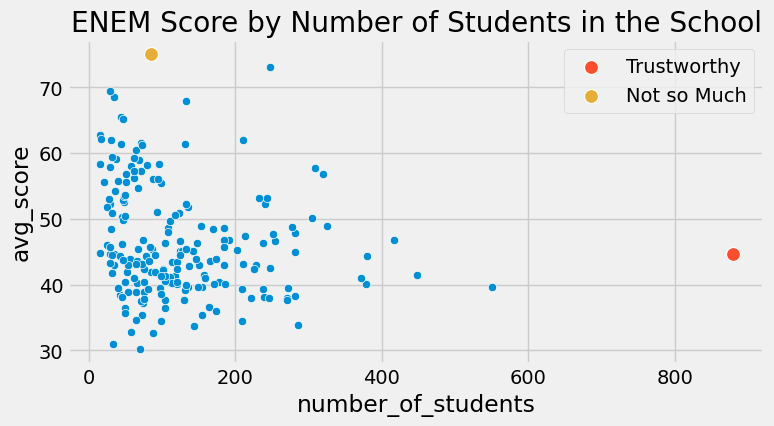

In [2]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

위 그림에서 왼쪽 점은 오른쪽 점보다 모델에 미치는 영향이 적어야 합니다. 오른쪽에 있는 점은 하나로 그룹화된 많은 데이터를 의미합니다. 데이터를 분리하고 그룹화되지 않은 데이터에 대해 선형 회귀를 돌린다면 왼쪽의 그룹화되지 않은 점보다 모델에 더 많은 기여를 할 것입니다.

높고 낮은 분산을 갖는 현상을 **heteroskasticity**(이분산성)이라 합니다. 쉽게 말해 `feature` 내 모든 값에 걸쳐 분산이 일정하지 않으면 이분산성이 있습니다. ENEM 데이터에서는 `feature` 값이 커짐에 따라 분산이 작아지는 것을 확인할 수 있습니다. 또 다른 예로 나이별로 임금을 표시하면 노인들의 임금 격차가 젊은이들보다 더 높다는 것을 알 수 있을 것입니다. 이분산성의 일반적인 이유는 그룹화입니다.

그룹화된 데이터는 매우 일반적입니다. 주로 정보 보호 때문입니다. 정부와 기업은 개인 데이터를 제공할 수 없습니다. 개인 정보 보호 요구 사항을 위반할 수 있기 때문입니다. 외부 연구자에게 데이터를 내보낼 때 데이터를 그룹화할 수 있습니다. 개인 데이터는 그룹화되고 더 이상 고유하게 식별되지 않게 됩니다.

다행히도 회귀 분석은 그룹화된 데이터를 잘 처리할 수 있습니다. 방법을 배우기 전에 먼저 임금과 교육에 관한 데이터와 같은 그룹화되지 않은 데이터를 살펴보겠습니다. 데이터 세트는 근로자당 한 줄씩 구성되어 있습니다. 따라서 각 개인의 임금과 교육 기간을 알고 있습니다.

In [3]:
wage = pd.read_csv("./data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


만약 회귀 모델로 교육 시간으로 시간당 임금의 로그 값을 추정한다면 아래와 같은 결과를 얻습니다.

In [4]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


이제 데이터가 제약을 받고 있다고 해보겠습니다. 데이터 제공자는 개별 데이터를 제공할 수 없습니다. 대신 교육 시간으로 그룹을 지어 평균적인 임금과 표본 개수만 제공합니다. 이제 10개 데이터만 남았습니다.

In [5]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


걱정마세요! 회귀 분석은 큰 데이터가 필요하지 않습니다! 할 수 있는 일은 선형 회귀 모델에 가중치를 주는 것입니다. 표본 크기가 작은 그룹보다 큰 그룹을 더 고려합니다. `smf.ols`를 `smf.wls`로 바꾼 것에 주목하세요. `smf.wls`은 가중 최소 제곱을 위한 함수입니다. 알아차리기 어렵지만 모든 것을 바꿀 것입니다.

In [6]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


그룹화된 모델에서 'educ'의 매개변수 추정치는 그룹화되지 않은 데이터의 매개변수 추정치에 매우 가깝습니다. (실제로 이 경우에는 같습니다.) 데이터 포인트가 10개뿐이더라도 통계적으로 유의한 결과를 얻을 수 있습니다. 몇 개 안되는 점을 가지고 있지만, 그룹화로 분산이 감소하기 때문입니다. 표준 오차와 `t` 통계량이 약간 큽니다. 분산에 대한 일부 정보가 손실되어 더 보수적이어야 하기 때문입니다. 데이터를 그룹화하면 각 그룹 내에서 분산이 얼마나 큰지 알 수 없습니다. 아래의 가중치가 없는 모델과 비교해 보세요.

In [7]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


모수 추정치가 더 작습니다. `model_3`은 모든 점에 대해 동일한 가중치를 줍니다. 그룹화된 점을 따라 모델 결과를 표시하면 가중치가 없는 모델은 왼쪽 아래의 작은 점에 필요보다 더 중요하게 여기는 것을 알 수 있습니다. 결과적으로 `model_3`의 기울기가 더 낮습니다.

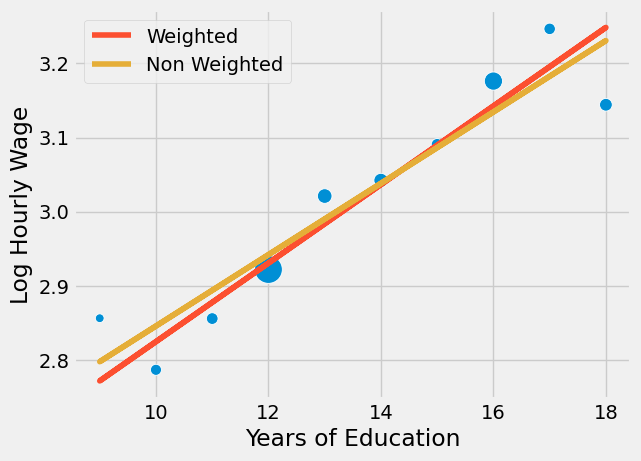

In [8]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

회귀 분석은 개별 데이터 또는 그룹화된 데이터 모두에서 작동하는 놀라운 도구이지만 후자는 가중치를 사용해야 합니다. 가중 회귀 분석을 사용하려면 평균 통계량이 필요합니다. 합, 표준 편차, 중앙값이 아니라 평균입니다! 공변량과 종속 변수 모두 평균이 필요합니다. 그룹화된 데이터의 가중 회귀 분석 결과는 그룹화되지 않은 데이터의 회귀 분석 결과와 정확히 일치하지는 않지만, 상당히 유사합니다.

![img](./data/img/dummy/heterosk.png)

그룹화된 데이터의 모델에서 추가 공변량을 사용하는 예시로 마무리하겠습니다.

In [9]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


예시에서는 교육 시간 외에 IQ를 `feature`로 포함했습니다. 메커니즘은 거의 같습니다. 평균값을 회귀시키고 개수를 가중치로 사용합니다.

## Regression for Dummies

`Dummy variable`(더미 변수)는 두 `column`으로 인코딩한 범주형 변수를 의미합니다. 모델에 포함할 성별 변수가 있다고 해봅시다. 이 변수는 남성, 여성, 기타 3가지 범주로 인코딩됩니다.

|gender|
|------|
|male  |
|female|
|female|
|other |
|male  |

선형 회귀는 숫자만 값으로 받기 때문에 이 범주 데이터를 숫자로 바꿔야 합니다. 따라서 더미 변수를 사용합니다. 각 변수는 범주의 존재를 나타내도록 0/1로 인코딩합니다. 한 개 범주는 기본 범주로 제외합니다. 마지막 범주는 다른 범주의 선형 조합이므로 이 작업이 필요합니다. 즉, 다른 정보들로 마지막 범주를 알 수 있습니다. 어떤 사람이 여성이나 다른 성별이 아니라면 남성이라고 추론할 수 있습니다.

|gender|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|

우리는 이미 A/B 테스트를 다룰 때 간단한 형태의 더미 변수를 다루었습니다. 일반적으로 이진 `treatment`를 다룰 때 더미 변수로 표현합니다. 이 경우 **더미에 대한 회귀 계수는 회귀선의 절편에 대한 증분** 또는 처치된 것과 처치되지 않은 데이터 간 평균의 차이입니다.

구체적으로 12학년에 졸업하는 것이 시간당 임금에 미치는 영향을 추정하는 문제를 고려해봅시다. (교란은 무시합니다.) 아래 코드에서 교육 기간이 12년 이상인지를 나타내는 `treatment` 더미 변수 `T`를 만들었습니다.

In [10]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


더미는 일종의 스위치 역할을 합니다. 더미가 켜져 있으면 예측값은 절편에 더미 계수를 더한 값입니다. 더미가 꺼져 있으면 예측값은 절편입니다.

In [11]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


어떤 사람이 12학년을 마치지 않았을 때 평균 소득은 19.9입니다. 12학년을 마치면 예측값 혹은 평균 소득은 24.8449(19.9405 + 4.9044)입니다. 더미 계수는 평균의 차이를 포착하는데 여기서는 4.9044입니다.

일반적으로 독립 변수가 이항이라면 마찬가지로 회귀 분석은 `ATE`를 완벽하게 포착합니다. 회귀는 조건부 기대 함수(CEF) $E[Y|X]$에 대한 선형 근사로 특정한 경우 CEF가 선형이기 때문입니다. 즉, $E[Y_i|T_i=0]=\alpha$와 $E[Y_i|T_i=1] = \alpha + \beta$를 정의할 수 있으며 아래 수식으로 이어집니다.

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

무작위 데이터는 $\beta$ 평균 혹은 `ATE`의 차이입니다.

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

추가 변수를 사용하면 더미 계수는 평균의 **조건부** 차이가 됩니다. 모델에 IQ를 추가한다고 가정해 보겠습니다. 더미 계수는 **IQ를 고정한 상태에서** 12학년을 졸업할 때 임금이 얼마나 증가할 것인지 알려줍니다. 예측값은 두 개의 평행선으로 표시됩니다. 평행선을 넘어가는 것은 것은 12학년을 마칠 때 기대하는 임금의 양을 말해줍니다. 효과가 언제나 일정하므로 IQ와 관계없이 모든 사람은 12학년을 졸업함으로써 같은 혜택을 받습니다.

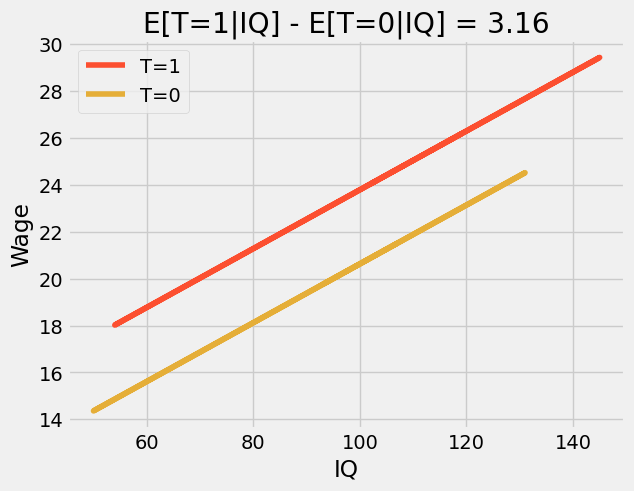

In [12]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

모델을 방정식에 대입하면 이유를 알 수 있습니다.

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

$\beta_1$은 평균의 조건부 차이이며 여기서는 3.16이라는 상수입니다. 상호작용 항을 추가하면 모델을 더 유연하게 만들 수 있습니다.

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i  + e_i
$

상황이 좀 더 복잡해집니다. 모델에서 각 매개변수가 의미하는 바를 살펴보겠습니다. 첫째로 절편인 $\beta_0$입니다. 특별히 흥미로운 해석은 가지고 있지 않습니다. `treatment`가 0이고(12학년을 졸업하지 않은 사람) IQ가 0일 때 예상되는 임금입니다. 누구도 IQ가 0일 것으로 생각하지 않으므로 $\beta_0$은 그다지 의미가 없습니다. $\beta_1$도 비슷합니다. $\beta_1$은 **IQ가 0일 때** 12학년을 마친다면 임금이 얼마나 오를지에 대한 기댓값을 의미합니다. IQ는 결코 0이 될 수 없으므로 특별한 의미는 없습니다. $\beta_2$는 흥미롭습니다. $\beta_2$는 **처치되지 않은 사람**의 임금이 IQ에 따라 어떻게 바뀌는지 말해줍니다. 여기서는 0.11 정도입니다. IQ가 1씩 증가할수록 12학년을 마치지 않은 사람은 시간당 추가적인 11센트를 얻을 것으로 기대됨을 의미합니다. 마지막으로 가장 흥미로운 매개 변수는 $\beta_3$입니다. $\beta_3$은 12학년 졸업에 대해 IQ의 효과를 의미합니다. 값은 0.024입니다. 즉, 12학년을 졸업하면 각 IQ 1점당 2센트가 추가됩니다. 큰 차이가 아닐 수 있지만, IQ가 60일 때와 140일 때를 비교해 봅시다. 첫 번째 사람은 임금이 1.44달러($60*0.024$) 인상되는 반면, IQ가 140인 사람은 12학년을 졸업할 때 추가로 3.36달러($140*0.024$)를 얻습니다.

상호작용 항은 `feature` 수준(이 예제에서는 IQ)에 따라 `treatment effect`를 바꿀 수 있습니다. 예측 선을 표시하면 더 이상 평행하지 않으며 12학년(T=1)을 졸업한 학생은 IQ에 대한 기울기가 높고 IQ가 높으면 졸업을 통해 더 많은 이점을 얻을 수 있습니다. 이러한 효과는 `modification` 혹은 `heterogeneous treatment effect`라 부릅니다.

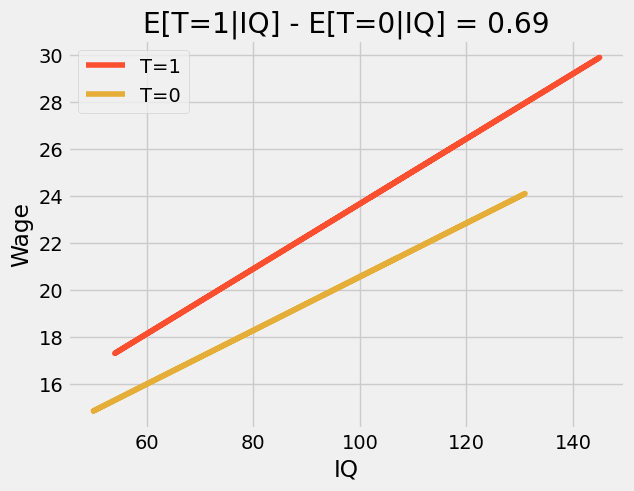

In [13]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

마지막으로 모델의 모든 변수가 더미인 경우를 살펴보겠습니다. IQ를 4개 `bin`으로 분리하고 교육 시간을 범주로 다룹니다.

In [14]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


교육을 하나의 범주로 취급하면서 더 이상 교육의 효과를 하나의 매개변수로 제한하지 않습니다. 교육의 각 범주가 고유한 영향을 주도록 허용하여 유연한 분석이 가능합니다. 모델은 단순히 각 교육 기간의 평균 임금을 계산합니다.

In [15]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


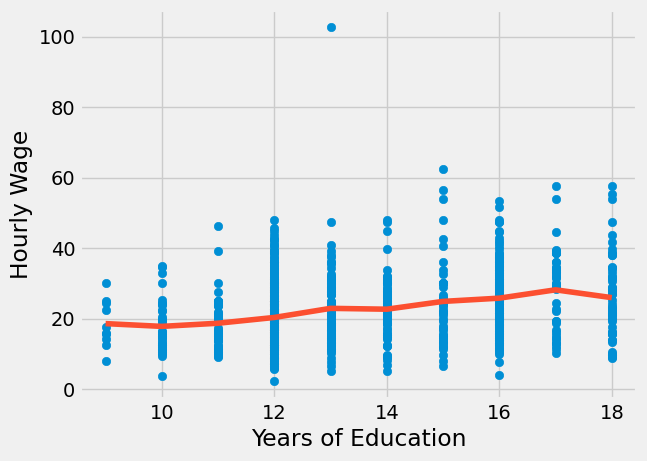

In [16]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

무엇보다도 범주화는 교육의 임금에 대한 함수(로그함수) 가정을 제거합니다. 더는 로그에 대해 걱정할 필요가 없습니다. 근본적으로 모델은 완전히 비모수적입니다. 모델이 하는 일은 각 교육 기간에 대한 임금의 표본 평균을 계산하는 것입니다. 결과는 `fitted line`이 특정한 형태를 보이지 않는 위 그림에서 확인할 수 있습니다. `fitted line`은 각 교육 기간에 대한 표본 평균의 내삽입니다. 예를 들어 17년 교육 하나의 매개변수로 재구성할 수 있습니다. 이 모델에서는 9.5905입니다. 아래 수식으로 교육 기간 9년과 17년간 개인 차이를 확인할 수 있습니다.

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

`trade-off`는 유연성을 허용할 때 통계적 중요성을 잃는다는 것입니다. p-값이 얼마나 큰지 확인해보세요.

In [17]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


모델에 더 많은 더미 공변량을 포함하면 교육에 대한 매개 변수는 각 더미 그룹에 대한 효과의 가중 평균이 됩니다.

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \ \}
$

$w(Group_i)$는 대체로 그룹 내 `treatment`의 분산 $Var(T_i|Group_i)$에 비례합니다. 그룹 가중치를 표본 크기로 하는 비모수 추정기를 사용하면 어떨까요? 실제로 유용한 방법이지만 회귀 분석으로는 할 수 없습니다.`treatment` 분산을 사용하면 회귀 분석으로 `treatment`가 많이 변하는 그룹에 가중치를 부여할 수 있습니다. 이는 직관적으로 이해할 수 있습니다. `treatment`가 거의 일정하다면 표본 크기는 문제 되지 않으며 `treatment effect`에 대한 정보를 주지 않을 것입니다.

In [18]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


![img](./data/img/dummy/you_little_shit.png)

## Key Ideas

6장에서는 일부 데이터가 다른 데이터보다 얼마나 중요한지를 살펴봄으로써 시작했습니다. 선형 모형을 추정할 때는 표본 크기가 크고 분산이 작은 표본에 더 많은 가중치를 줘야 합니다. 모델에서 가중치를 사용하는 경우 그룹화된 익명 데이터를 우아하게 처리할 수 있음을 확인했습니다.

다음으로 더미 회귀 분석을 공부했습니다. `treatment`가 `outcome`에 어떻게 영향을 주는지에 대한 함수를 가정하지 않는 비모수 모델을 만드는 방법을 살펴보았습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).